In [1]:
import torch
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_scatter import scatter_mean, scatter_softmax
from torch_geometric.nn import MetaLayer
from torch_geometric.data import Data, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.insert (0,'../python')
import bbll
import multiprocessing
import json
from array import array
import numpy as np 
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import shuffle
from importlib import reload
import swats
import numpy as np
from torch_geometric.data import InMemoryDataset

Welcome to JupyROOT 6.22/06


In [2]:
weight_name = "weightr"
num_fold = 5
variable_names=[weight_name,'MJJ','dEtaJJ','PtZZJJOHtZZJJ','MZZ','PtZZ','EtaJ1xJ2','Z1Cen','Z2Cen','YZ1Star','YZ2Star','MZ1','MZ2',
               'PtL1','EtaL1','PhiL1','EL1','PIDL1',
               'PtL2','EtaL2','PhiL2','EL2','PIDL2',
               'PtL3','EtaL3','PhiL3','EL3','PIDL3',
               'PtL4','EtaL4','PhiL4','EL4','PIDL4',
               'PtJ1','EtaJ1','PhiJ1','EJ1','PIDJ1',
               'PtJ2','EtaJ2','PhiJ2','EJ2','PIDJ2']
unused_variable=[weight_name]
#unused_variable=[weight_name,"is_em","is_me","is_ee","is_mm",'process_id']
#unused_variable=[weight_name,"is_em","is_me",'process_id',"m_hh_truth","bb_m","bb_deltar","ll_m"]
dim = len(variable_names)-len(unused_variable)

In [3]:
parameter_list = {}
parameter_list["sample_path"] = "/home/shuzhou/Documents/diff-4l/mva/sample-train-1220"
#parameter_list["sample_path"] = "/lustre/samples/di-higgs/sample-applied-0501"
parameter_list["sample_name1"] = "tree_ewk.root"
#parameter_list["sample_name2"] = "tree_bkg_reweighted.root"
parameter_list["sample_name2"] = "tree_QCD.root"
parameter_list["ntuple_name"] = ["tree_NOMINAL"]
parameter_list["sample_num"] = 2 
parameter_list["variable_list"] = variable_names 
parameter_list["weight_name"] = weight_name
parameter_list["unused_variable"] = unused_variable
parameter_list["label_list"] = [1,0]
parameter_list["do_reweight"] = True
parameter_list["cut_num"] = 1
parameter_list["cut1_type"] = "all"
parameter_list["cut1"] = '(DF["MJJ"]>300)&((DF["dEtaJJ"]>2.0)|(DF["dEtaJJ"]<-2.0))'
parameter_list["cut1_samples"] = [1]
parameter_list["ispDNN"] = False
parameter_list["tag_variable"] = "m_hh_truth"
parameter_list["target_sample"] = [1]
parameter_list["sample_to_fill"] = [2,3,4]
parameter_list["get_correlation_matrix"] = True
parameter_list["figures_path"] = "../figures/1213"
parameter_list["do_shuffle"] = True
parameter_list["do_normalization"]=True
parameter_list["ratio_list"] = [1,1]

In [4]:
out_list = bbll.create_dataset(parameter_list)

Start loading files


../python/bbll/preprocess.py:335: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame_list["sample"+str(i)]["label"] = label_list[i] # create label to each sample
/home/shuzhou/anaconda3/lib/python3.8/site-packages/cuda_guass_normal/__init__.py:216: RuntimeWarning: invalid value encountered in double_scalars
  result[i,j] = result[i,j]/sqrt(var_vec[i]*var_vec[j])
/home/shuzhou/anaconda3/lib/python3.8/site-packages/cuda_guass_normal/__init__.py:218: RuntimeWarning: invalid value encountered in double_scalars
  result[j,i] = result[j,i]/sqrt(var_vec[i]*var_vec[j])


correlation matrix saved at: ../figures/1213
correlation matrix saved at: ../figures/1213
sample1 yield before reweight is: 19.718600701136765
sample1 yield after reweight is: 86.0947902623901
sample2 yield before reweight is: 86.09479026239012
sample2 yield after reweight is: 86.09479026239012
dataset is successfully constructed!


In [5]:
drop_variable = unused_variable.copy()
drop_variable.append("label")

train_df, test_df = bbll.split_sample(out_list, 0.2)

train_label_df = train_df["label"]
train_weight_df = train_df[weight_name]
test_label_df = test_df["label"]
test_weight_df = test_df[weight_name]
train_data_df = train_df.drop(columns = drop_variable)
test_data_df = test_df.drop(columns = drop_variable)

In [6]:
train_variable = out_list['training_variable']
global_dim = train_variable.index('MZ2')+1
node_dim = 5
edge_dim = 3
tag_num = 6

In [7]:
drop_variable = unused_variable.copy()
drop_variable.append("label")

train_df, test_df = bbll.split_sample(out_list, 0.2)

train_label_df = train_df["label"]
train_weight_df = train_df[weight_name]
test_label_df = test_df["label"]
test_weight_df = test_df[weight_name]
train_data_df = train_df.drop(columns = drop_variable)
test_data_df = test_df.drop(columns = drop_variable)

In [8]:
from bbll.cuda_util import *
import cuda_guass_normal
from math import *

In [9]:
def create_edge(num_nodes):
    edge_ind = torch.ones((2,num_nodes*(num_nodes-1)))
    counter = 0
    for i in range(0,num_nodes):
        for j in range(0,num_nodes):
            if(i==j):
                continue
            edge_ind[0,counter]=i
            edge_ind[1,counter]=j
            counter+=1
    edge_ind=edge_ind.long()
    return(edge_ind)

In [10]:
def create_graphs(inputDF, weight_df, label_df, global_dim, tag_num, mean_vec,var_vec, batch_size):
    graphs = []
    reload(cuda_guass_normal)
    print("stage1")
    data = cuda_guass_normal.guass_normal_cuda(inputDF.values, mean_vec, var_vec)
    gl = data[:,0:global_dim]
    nodes = data[:,global_dim:]
    nrow, ncol = nodes.shape
    print("stage2")
    for i in range(nrow):
        nnodes = tag_num
        edge_ind = create_edge(nnodes)
        glob = gl[i]
        glob = glob.reshape(-1,global_dim)
        node = nodes[i]
        nd = node[0:5*nnodes]
        nd = nd.reshape(nnodes,5)
        
        edge_att = torch.ones(nnodes*(nnodes-1),3)
        counter = 0
        for s in range(0,nnodes):
            for t in range(0,nnodes):
                if(s==t):
                    continue
                edge_att[counter,0] = nd[s,1]-nd[t,1]
                edge_att[counter,1] = nd[s,2]-nd[t,2]
                edge_att[counter,2] = sqrt(edge_att[counter,0]*edge_att[counter,0]+edge_att[counter,1]*edge_att[counter,1])
                counter+=1
        data = Data(x=torch.from_numpy(nd).float(),edge_index=edge_ind, edge_attr = edge_att.float(), y = torch.from_numpy(glob).float())
        graphs.append(data)
        if(i%1000==0):
            print("process entry{0}".format(i))
    weight_tensor = torch.tensor(weight_df.values, dtype = torch.float)
    label_tensor = torch.tensor(label_df.values, dtype = torch.float)
    dataset = torch.utils.data.TensorDataset(weight_tensor, label_tensor)
    util_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle=False)
    #graph_dataset = MyOwnDataset('/home/shuzhou/Documents/diff-4l/mva/jupyter',data_list = graphs)
    graph_loader = DataLoader(graphs, batch_size = batch_size)
        
    return(util_loader, graph_loader)

In [11]:
train_util, train_graphs = create_graphs(train_data_df,train_weight_df, train_label_df,global_dim,tag_num,out_list['mean_vec'],out_list['var_vec'], 1000)

stage1
stage2
process entry0
process entry1000
process entry2000
process entry3000
process entry4000
process entry5000
process entry6000
process entry7000
process entry8000
process entry9000
process entry10000
process entry11000
process entry12000
process entry13000
process entry14000
process entry15000
process entry16000
process entry17000
process entry18000
process entry19000
process entry20000
process entry21000
process entry22000
process entry23000
process entry24000
process entry25000
process entry26000
process entry27000
process entry28000
process entry29000
process entry30000
process entry31000
process entry32000
process entry33000
process entry34000
process entry35000
process entry36000
process entry37000
process entry38000
process entry39000
process entry40000
process entry41000
process entry42000
process entry43000
process entry44000
process entry45000
process entry46000
process entry47000
process entry48000
process entry49000
process entry50000
process entry51000
process ent

In [12]:
test_util, test_graphs = create_graphs(test_data_df,test_weight_df, test_label_df,global_dim,tag_num,out_list['mean_vec'],out_list['var_vec'], 1000)

stage1
stage2
process entry0
process entry1000
process entry2000
process entry3000
process entry4000
process entry5000
process entry6000
process entry7000
process entry8000
process entry9000
process entry10000
process entry11000
process entry12000
process entry13000
process entry14000
process entry15000
process entry16000
process entry17000
process entry18000
process entry19000
process entry20000
process entry21000
process entry22000
process entry23000
process entry24000
process entry25000
process entry26000
process entry27000
process entry28000
process entry29000
process entry30000
process entry31000
process entry32000
process entry33000
process entry34000
process entry35000
process entry36000
process entry37000
process entry38000
process entry39000
process entry40000
process entry41000
process entry42000
process entry43000
process entry44000


In [66]:
device = torch.device("cuda") 

In [67]:
class one_step_attention(nn.Module):
    def __init__(self, input_dim):
        super(one_step_attention, self).__init__()
        self.input_dim = input_dim
        self.atten = nn.Linear(self.input_dim, 10)
        self.act1 = nn.ReLU()
        self.enger = nn.Linear(10,1)
        
    def forward(self, inp):
        atten = self.atten(inp)
        act1 = self.act1(atten)
        en = self.enger(act1)
        return(en)

In [68]:
class EdgeModel(torch.nn.Module):
    def __init__(self,ndim,edim,udim,odim,hdim):
        super(EdgeModel, self).__init__()
        self.edge_mlp = Seq(Lin(ndim*2+edim+udim, hdim), ReLU(), Lin(hdim, odim), ReLU())

    def forward(self, src, dest, edge_attr, u, batch):
        # source, target: [E, F_x], where E is the number of edges.
        # edge_attr: [E, F_e]
        # u: [B, F_u], where B is the number of graphs.
        # batch: [E] with max entry B - 1.
        out = torch.cat([src, dest, edge_attr, u[batch]], 1)
        return self.edge_mlp(out)

In [69]:
class NodeModel(torch.nn.Module):
    def __init__(self,ndim,edim,udim,odim,hdim):
        super(NodeModel, self).__init__()
        self.node_mlp_1 = Seq(Lin(ndim+edim, hdim), ReLU(), Lin(hdim, hdim),ReLU())
        self.node_mlp_2 = Seq(Lin(ndim+hdim+udim, hdim), ReLU(), Lin(hdim, odim),ReLU())
    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index
        out = torch.cat([x[row], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        out = scatter_mean(out, col, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out, u[batch]], dim=1)
        return self.node_mlp_2(out)

In [70]:
class GlobalModel(torch.nn.Module):
        def __init__(self,ndim,udim,odim,hdim):
            super(GlobalModel, self).__init__()
            self.global_mlp = Seq(Lin(ndim+udim, hdim), ReLU(), Lin(hdim, odim),ReLU())
            self.attention = one_step_attention(ndim)

        def forward(self, x, edge_index, edge_attr, u, batch):
                # x: [N, F_x], where N is the number of nodes.
                # edge_index: [2, E] with max entry N - 1.
                # edge_attr: [E, F_e]
                # u: [B, F_u]
                # batch: [N] with max entry B - 1.
                atten = self.attention(x)
                #atten = atten.reshape(-1,1)
                score = scatter_softmax(atten, batch,dim=0)
                x =x*score
                out = torch.cat([u, scatter_mean(x, batch, dim=0)], dim=1)
                return self.global_mlp(out)

In [71]:
class GNN(torch.nn.Module):
    def __init__(self, ngnn, gnn_list, out_dim):
        super(GNN, self).__init__()
        self.ngnn = ngnn
        self.out_dim = out_dim
        ndim,edim,udim,ndim_o,edim_o,udim_o = gnn_list[0]
        edge_layer = EdgeModel(ndim,edim,udim,edim_o,20)
        node_layer = NodeModel(ndim,edim_o,udim,ndim_o,50)
        global_layer = GlobalModel(ndim_o,udim,udim_o,100)
        self.gnn1 = MetaLayer(edge_layer,node_layer,global_layer)
        
        
        ndim,edim,udim,ndim_o,edim_o,udim_o = gnn_list[1]
        edge_layer = EdgeModel(ndim,edim,udim,edim_o,20)
        node_layer = NodeModel(ndim,edim_o,udim,ndim_o,50)
        global_layer = GlobalModel(ndim_o,udim,udim_o,100)
        self.gnn2 = MetaLayer(edge_layer,node_layer,global_layer)
        
        ndim,edim,udim,ndim_o,edim_o,udim_o = gnn_list[2]
        edge_layer = EdgeModel(ndim,edim,udim,edim_o,20)
        node_layer = NodeModel(ndim,edim_o,udim,ndim_o,50)
        global_layer = GlobalModel(ndim_o,udim,udim_o,100)
        self.gnn3 = MetaLayer(edge_layer,node_layer,global_layer)
        
        ndim,edim,udim,ndim_o,edim_o,udim_o = gnn_list[3]
        edge_layer = EdgeModel(ndim,edim,udim,edim_o,20)
        node_layer = NodeModel(ndim,edim_o,udim,ndim_o,50)
        global_layer = GlobalModel(ndim_o,udim,udim_o,100)
        self.gnn4 = MetaLayer(edge_layer,node_layer,global_layer)
        
        ndim,edim,udim,ndim_o,edim_o,udim_o = gnn_list[-1]
        self.attention = one_step_attention(ndim_o)
        self.ln = Lin(ndim_o+udim_o,out_dim)
        self.out_act = nn.Sigmoid()
        
        
    def forward(self, x, edge_index, edge_attr, u, batch):
        x, edge_attr, u = self.gnn1(x,edge_index,edge_attr, u, batch)
        x, edge_attr, u = self.gnn2(x,edge_index,edge_attr, u, batch)
        x, edge_attr, u = self.gnn3(x,edge_index,edge_attr, u, batch)
        x, edge_attr, u = self.gnn4(x,edge_index,edge_attr, u, batch)
        atten = self.attention(x)
        #atten = atten.reshape(-1,1)
        score = scatter_softmax(atten, batch,dim=0)
        x = score*x
        x = scatter_mean(x,batch,dim=0)
        gnn_out = torch.cat([x,u],1)
        out = self.ln(gnn_out)
        if(self.out_dim ==1):
            out = self.out_act(out)
        return(out)

In [72]:
nfeature_dim = 5
efeature_dim = 3
gfeature_dim = 12
gnn_list = [[nfeature_dim,efeature_dim,gfeature_dim,50,5,100],[50,5,100,50,10,100],[50,10,100,50,10,100],[50,10,100,50,10,100]]

In [73]:
loss_function = nn.BCELoss().cuda()
model = GNN(4,gnn_list,1).to(device)
optimizer = swats.SWATS(model.parameters())

In [74]:
def train(model, device, graph_loader, util_loader, loss_function, optimizer, epoch, num_class):
    model.train()
    average_loss=0
    batch_n=0
    for batch_idx, (graph, (weight, label)) in enumerate(zip(graph_loader, util_loader)):
        batch_n=batch_n+1
        graph, sample_weight, target = graph.to(device), weight.to(device), label.to(device)
        batch, edge_attr, edge_index, x, u = graph.batch, graph.edge_attr, graph.edge_index, graph.x, graph.y
        optimizer.zero_grad()
        output = model(x,edge_index, edge_attr, u, batch)
        #my_weight=sample_weight/sample_weight.mean()
        if(num_class == 2):
            loss_function.weight = sample_weight/sample_weight.mean()
            output=output.reshape(-1)
            loss = loss_function(output, target)
            #loss = custom_loss(output, target,my_weight)
            loss.backward()
            average_loss=average_loss+loss.item()
        else:
            target = target.long()
            loss = loss_function(output, target)
            loss = loss * sample_weight/sample_weight.mean()
            loss = loss.mean()
            loss.backward()
            average_loss=average_loss+loss.item()
        optimizer.step()
        torch.cuda.empty_cache()
        n1, n2 = u.shape
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * n1, len(util_loader.dataset),
                100. * batch_idx / len(util_loader), loss.item()))
    print("Average loss in epoch ",epoch," is: ",average_loss/batch_n)
    return(average_loss/batch_n)       

In [75]:
def eval_train(model,device, graph_loader, util_loader,loss_function, num_class):
    average_loss=0
    batch_n=0
    model.eval()
    with torch.no_grad():
         for batch_idx, (graph, (weight, label)) in enumerate(zip(graph_loader, util_loader)):
            batch_n=batch_n+1
            graph, sample_weight, target = graph.to(device), weight.to(device), label.to(device)
            batch, edge_attr, edge_index, x, u = graph.batch, graph.edge_attr, graph.edge_index, graph.x, graph.y
            output = model(x,edge_index, edge_attr, u, batch)
            if(num_class == 2):
                output=output.reshape(-1)
                loss_function.weight = sample_weight/sample_weight.mean()
                loss = loss_function(output, target)
                average_loss=average_loss+loss.item()
            else:
                target = target.long()
                loss = loss_function(output, target)
                loss = loss * sample_weight/sample_weight.mean()
                average_loss=average_loss+loss.mean().item()
    return(average_loss/batch_n)

In [76]:
def eval_gnn(model,device, graph_loader, num_class):
    i=0
    model.eval()
    with torch.no_grad():
        for batch_idx, (graph) in enumerate(graph_loader):
            graph = graph.to(device)
            batch, edge_attr, edge_index, x, u = graph.batch, graph.edge_attr, graph.edge_index, graph.x, graph.y
            score = model(x,edge_index, edge_attr, u, batch)
            if(num_class>2):
                score = nn.functional.softmax(score, dim = 1)
            del x
            del edge_index
            del edge_attr
            del u
            del batch
            del graph
            score_np=score.data.cpu().numpy()
            if(i==0):
                output_numpy=score_np
            if(i!=0):
                output_numpy=np.vstack((output_numpy,score_np))
            i=i+1
            torch.cuda.empty_cache()
    if(num_class == 2):
        return(output_numpy[0:,0])
    else:
        return(output_numpy[0:,:])

In [77]:
def train_model(model, device, train_graph_loader, test_graph_loader, train_util_loader, test_util_loader, loss_fn, optimizer, max_epoch, patient, num_class):
    lowest_loss=9999
    counter=0
    best_epoch=0
    pat=patient
    loss_np=np.zeros((max_epoch,1))
    loss_test_np=np.zeros((max_epoch,1))
    for epoch in range(1, max_epoch):
        loss_epoch=train(model, device, train_graph_loader, train_util_loader,loss_fn, optimizer, epoch, num_class)
        loss_test_epoch=eval_train(model, device, test_graph_loader, test_util_loader,loss_fn, num_class)
        loss_np[epoch-1]=loss_epoch
        loss_test_np[epoch-1]=loss_test_epoch
        if(loss_test_epoch<lowest_loss):
            counter=0
            best_epoch=epoch
            lowest_loss=loss_test_epoch
            torch.save(model.state_dict(),'training-temp-vbszz.pt')
        else:
            counter=counter+1
        if(counter==pat):
            print("Stopping, best epoch is: ",best_epoch," lowest loss is: ",lowest_loss)
            model.load_state_dict(torch.load('training-temp-vbszz.pt'))
            break
    return(loss_np,loss_test_np,best_epoch)

In [78]:
train_model(model, device, train_graphs, test_graphs, train_util, test_util, loss_function, optimizer, 300, 4, 2)

Train Epoch: 1 [0/177848 (0%)]	Loss: 0.693468
Train Epoch: 1 [10000/177848 (6%)]	Loss: 0.692487
Train Epoch: 1 [20000/177848 (11%)]	Loss: 0.679717
Train Epoch: 1 [30000/177848 (17%)]	Loss: 0.562685
Train Epoch: 1 [40000/177848 (22%)]	Loss: 0.469207
Train Epoch: 1 [50000/177848 (28%)]	Loss: 0.470320
Train Epoch: 1 [60000/177848 (34%)]	Loss: 0.451625
Train Epoch: 1 [70000/177848 (39%)]	Loss: 0.475095
Train Epoch: 1 [80000/177848 (45%)]	Loss: 0.451590
Train Epoch: 1 [90000/177848 (51%)]	Loss: 0.461466
Train Epoch: 1 [100000/177848 (56%)]	Loss: 0.509701
Train Epoch: 1 [110000/177848 (62%)]	Loss: 0.498699
Train Epoch: 1 [120000/177848 (67%)]	Loss: 0.441871
Train Epoch: 1 [130000/177848 (73%)]	Loss: 0.443442
Train Epoch: 1 [140000/177848 (79%)]	Loss: 0.453656
Train Epoch: 1 [150000/177848 (84%)]	Loss: 0.439069
Train Epoch: 1 [160000/177848 (90%)]	Loss: 0.449507
Train Epoch: 1 [170000/177848 (96%)]	Loss: 0.452322
Average loss in epoch  1  is:  0.5003416195009531
Train Epoch: 2 [0/177848 (0%)]

(array([[0.50034162],
        [0.44255293],
        [0.43775549],
        [0.4350169 ],
        [0.43310407],
        [0.43176808],
        [0.430666  ],
        [0.42955396],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0

In [82]:
model.load_state_dict(torch.load('training-temp-vbszz.pt'))

<All keys matched successfully>

In [83]:
train_score = eval_gnn(model, device, train_graphs, 2)
test_score = eval_gnn(model, device, test_graphs, 2)

In [84]:
train_label = train_label_df.values
test_label = test_label_df.values
train_weight = train_weight_df.values
test_weight = test_weight_df.values

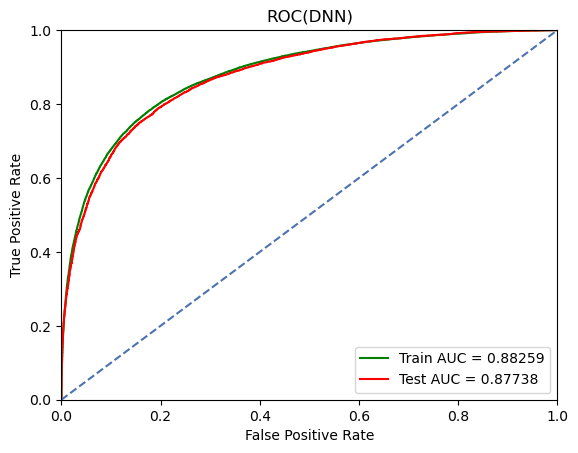

In [85]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(train_label,train_score,sample_weight=train_weight)
roc_auc_train = sklearn.metrics.auc(fpr, tpr)

fprt, tprt, threshold=sklearn.metrics.roc_curve(test_label,test_score,sample_weight=test_weight)
roc_auc_test = sklearn.metrics.auc(fprt, tprt)

plt.style.use('default')
plt.title('ROC(DNN)')
plt.plot(fpr, tpr, 'b',label = 'Train AUC = %0.5f' % roc_auc_train,color='green')
plt.plot(fprt, tprt, 'b',label = 'Test AUC = %0.5f' % roc_auc_test,color='red')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/1213/roc-GNN.pdf', format='pdf', dpi=500)
plt.show()